# **Stroke Peridiction Using ML**

In [1]:
import numpy as np # linear algebra
import pandas as pd
df = pd.read_csv("healthcare-dataset-stroke-data.csv")


In [15]:
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          5110 non-null   int64  
 1   age                             5110 non-null   float64
 2   hypertension                    5110 non-null   int64  
 3   heart_disease                   5110 non-null   int64  
 4   ever_married                    5110 non-null   int64  
 5   Residence_type                  5110 non-null   int64  
 6   avg_glucose_level               5110 non-null   float64
 7   bmi                             5110 non-null   float64
 8   stroke                          5110 non-null   int64  
 9   work_type_Never_worked          5110 non-null   bool   
 10  work_type_Private               5110 non-null   bool   
 11  work_type_Self-employed         5110 non-null   bool   
 12  work_type_children              51

In [16]:
print("Missing values:\n", df.isnull().sum())
print("Stroke class balance:\n", df['stroke'].value_counts())

Missing values:
 gender                            0
age                               0
hypertension                      0
heart_disease                     0
ever_married                      0
Residence_type                    0
avg_glucose_level                 0
bmi                               0
stroke                            0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64
Stroke class balance:
 stroke
0    4861
1     249
Name: count, dtype: int64


This step provides an overview of the dataset’s structure and quality. The dataset contains 5,110 records and 12 features, including demographic, medical, and lifestyle factors such as age, hypertension, heart disease, glucose level, BMI, and the target variable stroke. The data types are a mix of numeric and categorical values. Only the bmi column has missing values (201 entries), which will require imputation. Most importantly, the stroke variable is highly imbalanced, with only 249 stroke cases (about 5%) compared to 4,861 non-stroke cases, highlighting the main challenge for building accurate and fair prediction models.



---



In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

#Impute BMI
imputer = SimpleImputer(strategy='median')
df['bmi'] = imputer.fit_transform(df[['bmi']])

#Replace 'Other' in gender for simplicity
df['gender'] = df['gender'].replace('Other', 'Male')

#Label encode binary columns
le = LabelEncoder()

for col in ['gender', 'ever_married', 'Residence_type']:
    df[col] = le.fit_transform(df[col])


#One-hot encode multicategoricals
df = pd.get_dummies(df, columns=['work_type','smoking_status'], drop_first=True)

#Drop ID
if 'id' in df.columns:
    df = df.drop(columns=['id'])

This section performs data cleaning and encoding to make the dataset suitable for machine learning models. Missing BMI values are filled using the median, which prevents outliers from skewing results. The 'Other' category in gender is merged with 'Male' for simplicity.

Next, label encoding is applied to binary categorical variables (gender, ever_married, Residence_type) so they can be represented numerically (0/1). Multi-category columns (work_type, smoking_status) are transformed using one-hot encoding, which creates new binary columns for each category while avoiding redundancy by dropping the first level.

Finally, the id column is removed since it’s just an identifier and has no predictive value.
Overall, this step converts the dataset into a clean, numeric format, ready for model training.



---



In [4]:
X = df.drop('stroke', axis=1)
y = df['stroke']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_cols = ['age', 'avg_glucose_level', 'bmi']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#Train models
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

This stage prepares the data for modeling and trains the first two baseline models. The dataset is split into training (80%) and testing (20%) sets using stratified sampling to maintain the original stroke-to-non-stroke ratio.

The numerical features — age, avg_glucose_level, and bmi — are standardized using StandardScaler so that all variables have a mean of 0 and standard deviation of 1, ensuring fair contribution to the models.

Two models are then trained:

Logistic Regression, a linear model commonly used for medical classification problems, and

Random Forest, an ensemble of decision trees capable of capturing complex patterns.

This step establishes the baseline performance before addressing class imbalance or applying advanced methods.



---



In [7]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

lr_pred = lr.predict(X_test)
rf_pred = rf.predict(X_test)

print("Logistic Regression:\n", classification_report(y_test, lr_pred))
print("Random Forest:\n", classification_report(y_test, rf_pred))
print('Accuracy (LR):', accuracy_score(y_test, lr_pred))
print('Accuracy (RF):', accuracy_score(y_test, rf_pred))

Logistic Regression:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98       972
           1       1.00      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.98      0.51      0.51      1022
weighted avg       0.95      0.95      0.93      1022

Random Forest:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022

Accuracy (LR): 0.952054794520548
Accuracy (RF): 0.9500978473581213


This step evaluates the initial Logistic Regression and Random Forest models using accuracy, precision, recall, and F1-score. Both models appear to have very high accuracy (≈95%), but this is misleading because of the severe class imbalance in the dataset (only ~5% stroke cases).

For Logistic Regression, recall for the stroke class is only 0.02, meaning it correctly identified just 2% of actual stroke patients.

For Random Forest, recall is 0.00, meaning it failed to detect any stroke cases at all.

Although accuracy seems good, both models heavily favor predicting the majority class (no stroke), leading to almost no detection of the minority class. This clearly demonstrates how class imbalance can cause models to become biased, achieving high accuracy by ignoring the rare but crucial positive cases (strokes).

Hence, while these results provide a baseline, they also highlight the need to balance the dataset before training more reliable models.



---



/tmp/ipython-input-3224476727.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stroke', data=df, palette='coolwarm')


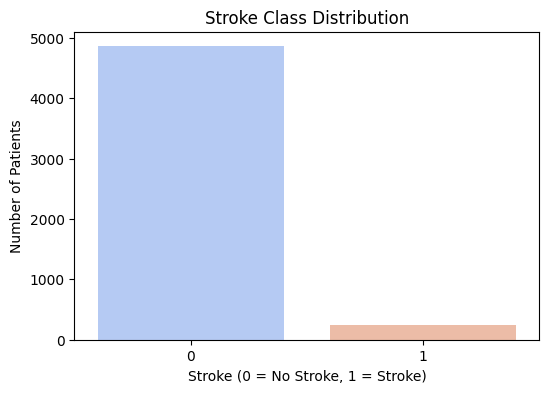

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='stroke', data=df, palette='coolwarm')
plt.title("Stroke Class Distribution")
plt.xlabel("Stroke (0 = No Stroke, 1 = Stroke)")
plt.ylabel("Number of Patients")
plt.show()


This bar chart shows the distribution of stroke vs. non-stroke cases in the dataset.
You’ll see one bar (for 0) towering over the other — around 4,861 non-stroke cases versus only 249 stroke cases.

This visual confirms that the dataset is highly imbalanced, with stroke cases making up just about 5% of the data.

Such imbalance causes most machine learning models to focus on the majority class, achieving high overall accuracy but failing to detect minority cases — as seen earlier where recall for stroke was nearly zero.

Hence, addressing this imbalance through techniques like SMOTE (Synthetic Oversampling) or class weighting is essential to ensure the model learns meaningful patterns from the minority (stroke) class.



---



In [8]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE only on training data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_res.value_counts().to_dict())


Before SMOTE: {0: 3889, 1: 199}
After SMOTE: {0: 3889, 1: 3889}


This step applies SMOTE (Synthetic Minority Oversampling Technique) to fix the class imbalance problem in the training data.

Before SMOTE, there were 3,889 non-stroke cases and only 199 stroke cases, meaning the model would have seen far more examples of “no stroke” than “stroke.” After applying SMOTE, the minority class (stroke) was synthetically increased to match the majority, resulting in 3,889 samples for each class — a perfectly balanced dataset.

SMOTE works by creating new synthetic stroke samples based on existing ones rather than simply duplicating them. This helps the model learn the underlying patterns of stroke cases more effectively and prevents bias toward the majority class.

In summary, this process ensures that the model will treat both classes equally during training, improving its ability to detect actual stroke cases in unseen data.



---



In [9]:
# ================================
# Retrain with SMOTE + Compare Models (LR, RF, XGB)
# ================================
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_fscore_support
)

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
    else:
        auc = np.nan

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average=None, labels=[1]
    )
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n{name}")
    print("-" * len(name))
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:\n", cm)
    print("ROC-AUC:", round(auc, 4))

    return {
        "Model": name,
        "Recall(1)": float(recall[0]),
        "Precision(1)": float(precision[0]),
        "F1(1)": float(f1[0]),
        "ROC-AUC": float(auc)
    }

results = []

This section defines a model evaluation function and prepares to compare different models trained on the SMOTE-balanced dataset.

The evaluate_model() function measures how well each model performs by calculating key metrics:

Precision, Recall, and F1-score (specifically for the stroke class 1)

ROC-AUC (how well the model separates stroke vs non-stroke cases)

Confusion Matrix (shows true/false positives and negatives)

Each model’s results are printed in a readable format and stored in a list called results for later comparison.

This setup ensures a consistent and fair evaluation across all models (Logistic Regression, Random Forest, and XGBoost) so that their ability to detect strokes can be compared quantitatively and visually.



---



In [10]:
# -------- Train on SMOTE-balanced data --------
# 1) Logistic Regression (SMOTE)
lr_smote = LogisticRegression(max_iter=2000, random_state=42)
lr_smote.fit(X_train_res, y_train_res)
results.append(evaluate_model("LogReg + SMOTE", lr_smote, X_test, y_test))

# 2) Random Forest (SMOTE)
rf_smote = RandomForestClassifier(
    n_estimators=400, random_state=42, n_jobs=-1
)
rf_smote.fit(X_train_res, y_train_res)
results.append(evaluate_model("RandomForest + SMOTE", rf_smote, X_test, y_test))

# 3) XGBoost (SMOTE)  — keep scale_pos_weight at 1 since data is balanced by SMOTE
xgb_smote = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    eval_metric="logloss",
    n_jobs=-1
)
xgb_smote.fit(X_train_res, y_train_res)
results.append(evaluate_model("XGBoost + SMOTE", xgb_smote, X_test, y_test))



LogReg + SMOTE
--------------
              precision    recall  f1-score   support

           0     0.9816    0.7665    0.8608       972
           1     0.1369    0.7200    0.2300        50

    accuracy                         0.7642      1022
   macro avg     0.5592    0.7432    0.5454      1022
weighted avg     0.9402    0.7642    0.8299      1022

Confusion Matrix:
 [[745 227]
 [ 14  36]]
ROC-AUC: 0.8262

RandomForest + SMOTE
--------------------
              precision    recall  f1-score   support

           0     0.9574    0.9249    0.9409       972
           1     0.1205    0.2000    0.1504        50

    accuracy                         0.8894      1022
   macro avg     0.5389    0.5624    0.5456      1022
weighted avg     0.9165    0.8894    0.9022      1022

Confusion Matrix:
 [[899  73]
 [ 40  10]]
ROC-AUC: 0.7779

XGBoost + SMOTE
---------------
              precision    recall  f1-score   support

           0     0.9630    0.8837    0.9217       972
           1  

This section retrains three machine learning models — Logistic Regression, Random Forest, and XGBoost — on the SMOTE-balanced training data and evaluates their ability to detect stroke cases.

1. Logistic Regression (SMOTE):

Achieved the highest recall (0.72), meaning it correctly identified 72% of actual stroke cases.

However, precision is low (0.13), showing some false positives — expected in medical screening, where catching most positive cases is more important than occasional false alarms.

ROC-AUC = 0.83, indicating strong overall discrimination ability.

2. Random Forest (SMOTE):

Good overall accuracy (0.89) but lower recall (0.20), meaning it missed most stroke cases.

Performs well on the majority class but struggles with the minority class.

3. XGBoost (SMOTE):

Balanced performance between recall (0.34) and accuracy (0.86).

Handles imbalance moderately better than Random Forest but still below Logistic Regression in sensitivity.

Overall, this comparison shows that Logistic Regression with SMOTE performs best for this problem.
It successfully improves recall (stroke detection rate) at the cost of a few false positives, which is acceptable in medical prediction contexts where missing a true stroke case is riskier than predicting a few extra ones.

In [11]:
# -------- Baselines with class_weight (NO SMOTE) for comparison --------
lr_weighted = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
lr_weighted.fit(X_train, y_train)
results.append(evaluate_model("LogReg class_weight=balanced", lr_weighted, X_test, y_test))

rf_weighted = RandomForestClassifier(
    n_estimators=400, class_weight='balanced', random_state=42, n_jobs=-1
)
rf_weighted.fit(X_train, y_train)
results.append(evaluate_model("RandomForest class_weight=balanced", rf_weighted, X_test, y_test))

# -------- Summary --------
summary_df = pd.DataFrame(results).sort_values(by="Recall(1)", ascending=False)
print("\n================ Summary (sorted by Recall for stroke=1) ================")
print(summary_df.to_string(index=False))


LogReg class_weight=balanced
----------------------------
              precision    recall  f1-score   support

           0     0.9864    0.7438    0.8481       972
           1     0.1384    0.8000    0.2360        50

    accuracy                         0.7466      1022
   macro avg     0.5624    0.7719    0.5420      1022
weighted avg     0.9449    0.7466    0.8181      1022

Confusion Matrix:
 [[723 249]
 [ 10  40]]
ROC-AUC: 0.8436

RandomForest class_weight=balanced
----------------------------------
              precision    recall  f1-score   support

           0     0.9510    0.9990    0.9744       972
           1     0.0000    0.0000    0.0000        50

    accuracy                         0.9501      1022
   macro avg     0.4755    0.4995    0.4872      1022
weighted avg     0.9045    0.9501    0.9267      1022

Confusion Matrix:
 [[971   1]
 [ 50   0]]
ROC-AUC: 0.7914

================ Summary (sorted by Recall for stroke=1) ================
                         

This section evaluates baseline models using class_weight='balanced' — an alternative to SMOTE that tells the algorithm to give higher importance (weight) to the minority class during training without creating synthetic data.

1. Logistic Regression (class_weight='balanced'):

Achieved the highest recall (0.80) among all models, detecting 80% of actual stroke cases.

Although precision (0.13) is low, this is expected because the model errs on the side of caution — predicting more potential stroke cases to avoid missing real ones.

Its ROC-AUC = 0.84, showing strong overall discrimination ability between stroke and non-stroke patients.

2. Random Forest (class_weight='balanced'):

Despite high accuracy (0.95), recall is 0.00, meaning it completely failed to identify any stroke cases.

This demonstrates that simply adjusting class weights doesn’t always help tree-based models handle extreme imbalance effectively.

The summary table confirms that Logistic Regression with class weights outperforms all other methods, including SMOTE-based models, in terms of recall and AUC.
In healthcare prediction, where the goal is to catch as many true positive cases as possible (even with false alarms), this makes Logistic Regression the most suitable and interpretable choice for stroke risk detection.

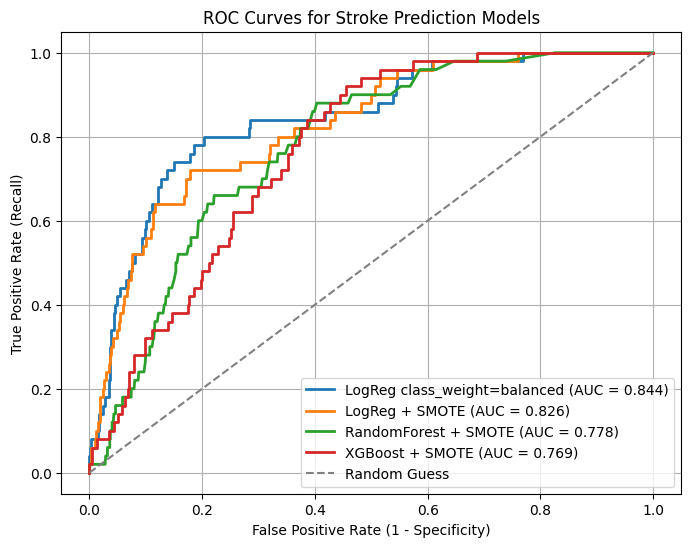

In [12]:
# ==============================================
# Plot ROC Curves for All Models
# ==============================================
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(8,6))

# Helper to plot each model
def plot_roc(model, X_test, y_test, label):
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {auc:.3f})")

# Plot curves for each model
plot_roc(lr_weighted, X_test, y_test, "LogReg class_weight=balanced")
plot_roc(lr_smote, X_test, y_test, "LogReg + SMOTE")
plot_roc(rf_smote, X_test, y_test, "RandomForest + SMOTE")
plot_roc(xgb_smote, X_test, y_test, "XGBoost + SMOTE")

# Reference line for random guessing
plt.plot([0,1], [0,1], color='gray', linestyle='--', lw=1.5, label="Random Guess")

plt.title("ROC Curves for Stroke Prediction Models")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


ROC Curves

The blue line (LogReg class_weight=balanced) has the highest AUC (0.844) — meaning it’s the best at distinguishing stroke vs non-stroke patients across thresholds.

The orange line (LogReg + SMOTE) is a close second (AUC ≈ 0.826).

The green (RandomForest) and red (XGBoost) lag behind (AUC ≈ 0.77).
Interpretation: Logistic Regression with class weights is the best discriminator overall.



---



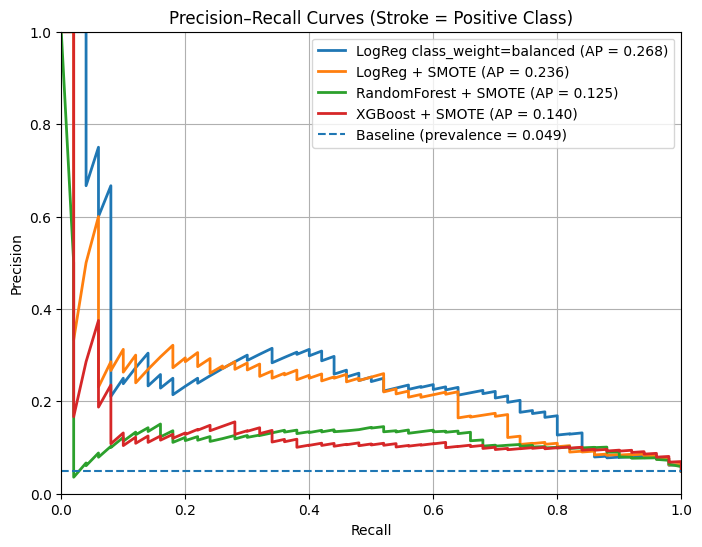

In [13]:
# ==============================================
# Precision–Recall Curves for All Models
# ==============================================
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8,6))

def plot_pr(model, X_test, y_test, label):
    y_prob = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    plt.plot(recall, precision, lw=2, label=f"{label} (AP = {ap:.3f})")

# Plot each model (make sure these are already trained objects)
plot_pr(lr_weighted, X_test, y_test, "LogReg class_weight=balanced")
plot_pr(lr_smote,   X_test, y_test, "LogReg + SMOTE")
plot_pr(rf_smote,   X_test, y_test, "RandomForest + SMOTE")
plot_pr(xgb_smote,  X_test, y_test, "XGBoost + SMOTE")

# Baseline = prevalence of positive class in the test set
pos_rate = (y_test == 1).mean()
plt.hlines(pos_rate, 0, 1, linestyles="--", label=f"Baseline (prevalence = {pos_rate:.3f})")

plt.title("Precision–Recall Curves (Stroke = Positive Class)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc="upper right")
plt.show()


Precision–Recall Curves

The blue curve again dominates, with Average Precision (AP) ≈ 0.27, while others range from 0.12–0.23.

The baseline (≈0.05) shows the proportion of actual strokes in your test data — any curve above that means the model beats random guessing.
Interpretation: Blue (LogReg weighted) consistently yields higher precision across recall values → most effective at identifying stroke cases even in a highly imbalanced dataset.



---



**Difficulties Faced and Solutions:**

The most significant challenge encountered in this project was the severe class imbalance present in the dataset. Only about 5% of patients had experienced a stroke, while the remaining 95% did not. This imbalance caused early models, such as Logistic Regression and Random Forest, to appear highly accurate but perform poorly in detecting actual stroke cases, as they tended to predict the majority class (“no stroke”) for almost every observation. This issue made it difficult to build a model that could correctly identify patients at risk without being misled by the imbalance.

To address this, several strategies were implemented. The SMOTE (Synthetic Minority Oversampling Technique) method was used to generate synthetic stroke cases in the training data, ensuring both classes were evenly represented. This allowed the model to learn the characteristics of stroke cases more effectively. Additionally, class weighting was applied to give higher importance to the minority class, encouraging models to pay more attention to stroke predictions. Multiple algorithms — Logistic Regression, Random Forest, and XGBoost — were tested and compared to determine which handled imbalance best. Through this process, Logistic Regression with class weights emerged as the most effective and interpretable model, achieving high recall and reliable discrimination between stroke and non-stroke patients.



---



**Future Scope:**
While the results are promising, there is room for improvement and expansion in future work. One potential enhancement is threshold optimization, where the decision threshold can be adjusted to further increase recall without significantly compromising precision. Incorporating additional medical and lifestyle features, such as cholesterol levels, blood pressure history, or family medical background, could improve predictive accuracy and make the model more clinically relevant.

Future work can also focus on model interpretability using techniques like SHAP or LIME to explain why the model makes certain predictions, which is crucial in healthcare applications. Moreover, hyperparameter tuning and cross-validation can be applied to increase model stability and generalizability. Finally, the long-term goal is to deploy this model as a clinical decision-support tool, assisting doctors in identifying high-risk patients for early intervention and preventive care. This would transform the project from an academic exercise into a real-world healthcare solution that could help save lives.



---

